In [1]:
import warnings
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import gensim as gs
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer()
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
warnings.filterwarnings('ignore')
import fasttext

In [2]:
train_dataset_1_1 = pd.read_csv('dataset/train_model_070_1M_title_meta_description.csv', delimiter=',')

In [3]:
train_dataset, validation_dataset = train_test_split(train_dataset_1_1, test_size=0.10, random_state=42)

In [4]:
embedding_model = gs.models.FastText.load('train_embedding_models/fasttext_embedding_50d')

In [14]:
MAX_PAD = 55

def sequence_padding(X_DIM, value):
    
    value_padding = np.pad(value, ((0,MAX_PAD - X_DIM),(0,0)), 'constant')
    
    return value_padding

In [15]:
def create_embedding(value):

    value = tknzr.tokenize(str(value))
    
    if len(value) < MAX_PAD:
        
        embedding = embedding_model.wv[value]
        embedding = embedding.astype('float16')
        
        padding_embedding = sequence_padding(embedding.shape[0],embedding)
        
        return padding_embedding
        
    else:
        
        embedding = embedding_model.wv[value[0:MAX_PAD]]
        
        return embedding

In [ ]:
train_article_title = []
train_article_meta_description = []
train_table_title = []
train_label = []

for i,row in tqdm(train_dataset.iterrows()):
    
    train_article_title.append(create_embedding(row['article_title']))
    train_article_meta_description.append(create_embedding(row['article_meta_description']))
    train_table_title.append(create_embedding(row['table_title']))
    train_label.append(row['label'])

In [ ]:
train_article_title = np.array(train_article_title, dtype='float16')
train_article_meta_description = np.array(train_article_meta_description, dtype='float16')
train_table_title = np.array(train_table_title, dtype='float16')
train_label = np.array(train_label1)

In [16]:
validation_article_title = []
validation_article_meta_description = []
validation_table_title = []
validation_label = []

for i, row in tqdm(validation_dataset.iterrows()):
    
    validation_article_title.append(create_embedding(row['article_title']))
    validation_article_meta_description.append(create_embedding(row['article_meta_description']))
    validation_table_title.append(create_embedding(row['table_title']))  
    validation_label.append(row['label'])

110671it [01:10, 1563.80it/s]


In [17]:
validation_article_title = np.array(validation_article_title, dtype='float16')
validation_article_meta_description = np.array(validation_article_meta_description, dtype='float16')
validation_table_title = np.array(validation_table_title, dtype='float16')
validation_label = np.array(validation_label)

In [18]:
validation_article_meta_description.shape

(110671, 55, 50)

In [ ]:
def coattention_method(query, document):
    
    transpose_document = tf.transpose(document,perm=[0, 2, 1])
    
    affinity = tf.matmul(query,transpose_document)
    
    return affinity

In [ ]:
def attention_model():
    
    article_title = tf.keras.Input(shape=(40,50), dtype='float32')
    article_meta_description = tf.keras.Input(shape=(40,50), dtype='float32')
    table_title = tf.keras.Input(shape=(40,50), dtype='float32')
    
    encodding_article_title = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32, return_sequences=True))(article_title)
    encodding_article_meta_description = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32, return_sequences=True))(article_meta_description)
    encodding_table_title = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32, return_sequences=True))(table_title)
    
    attention_title_title = coattention_method(encodding_article_title,encodding_table_title)
    attention_meta_title = coattention_method(encodding_article_meta_description,encodding_table_title)
    
    encodding_attention_title_title = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32, return_sequences=True))(attention_title_title)
    encodding_attention_meta_title = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32, return_sequences=True))(attention_meta_title)
    
    learned_vector_title_title = tf.keras.layers.Flatten()(encodding_attention_title_title)
    learned_vector_meta_title = tf.keras.layers.Flatten()(encodding_attention_meta_title)
    
    concat_learned_vector = tf.keras.layers.Concatenate()([learned_vector_title_title, learned_vector_meta_title])
   
    dense1 = tf.keras.layers.Dense(512, activation='relu')(concat_learned_vector)
    dropout1 = tf.keras.layers.Dropout(0.5, name="dropout1")(dense1)
    dense2 = tf.keras.layers.Dense(256, activation='relu')(dropout1)
    dropout2 = tf.keras.layers.Dropout(0.5, name="dropout2")(dense2)
    dense3 = tf.keras.layers.Dense(128, activation='relu')(dropout2)
    dropout3 = tf.keras.layers.Dropout(0.5, name="dropout3")(dense3)
    prediction = tf.keras.layers.Dense(1,activation='sigmoid')(dropout3)
    
    model = tf.keras.Model(inputs=[article_title, article_meta_description,table_title],outputs=prediction)
    
    return model

In [ ]:
model = attention_model()

In [ ]:
model.compile(loss="binary_crossentropy",optimizer="adam", metrics=['accuracy'])

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('GRU_affinity_model_070_1M_title_meta_description.h5', monitor='val_acc',verbose=1, save_the_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
history = model.fit([train_article_title,train_article_meta_description, train_table_title], train_label, 
          epochs=10, 
          batch_size=32, 
          validation_data=([validation_article_title,validation_article_meta_description, validation_table_title], validation_label),
          callbacks=callbacks_list)

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [11]:
model = tf.keras.models.load_model('GRU_affinity_model_070_1M_title_meta_description.h5')

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [19]:
y_prob = model.predict([validation_article_title,validation_article_meta_description,validation_table_title])
y_predict = (y_prob > 0.5).astype(np.int)
accuracy_score(validation_label, y_predict)

0.9759376891868692

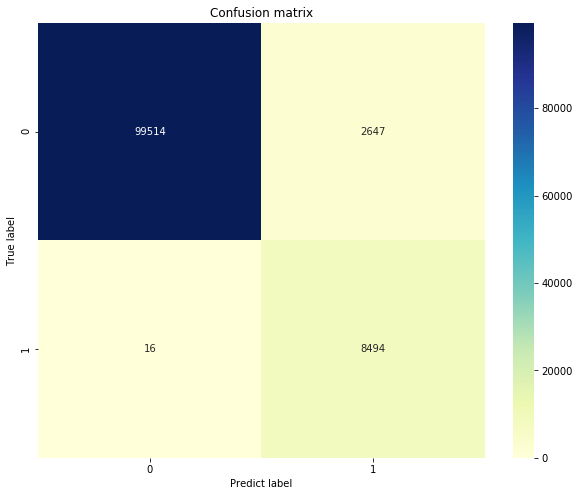

In [20]:
import seaborn as sns
import sklearn.metrics
confusion_matrix = sklearn.metrics.confusion_matrix(validation_label, y_predict)

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="YlGnBu")#, annot_kws={"size": 15});
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predict label')
plt.show()